# Plus court chemin passant par tous les noeuds d'un graphe

Dans le cas présent, le graphe est totalement connecté puisque chaque noeud est connecté à tous les autres. On commence par tiré des villes aléatoires.

## Distance

In [2]:
import numpy


def random_cities(n):
    return numpy.random.randn(n, 2)


random_cities(3)

array([[ 1.39190158,  0.70104769],
       [-0.865672  ,  1.22913836],
       [ 1.65596723, -0.32503514]])

Ensuite vient la distance du circuit avec les villes dans l'ordre dans lequel elles apparaissent.

In [3]:
def distance_boucle(cities):
    d = 0
    for i in range(cities.shape[0]):
        dx = cities[i - 1, 0] - cities[i, 0]
        dy = cities[i - 1, 1] - cities[i, 1]
        d += (dx**2 + dy**2) ** 0.5
    return d


cities = numpy.array([[0, 0], [1, 1]])
distance_boucle(cities)

2.8284271247461903

La même fonction sans boucle et avec numpy.

In [4]:
def distance(cities):
    d = ((cities[:-1] - cities[1:]) ** 2).sum(axis=1) ** 0.5
    d2 = ((cities[0] - cities[-1]) ** 2).sum() ** 0.5
    return d.sum() + d2


cities = numpy.array([[0, 0], [0, 2], [2, 2], [2, 0]])
distance(cities)

8.0

On mesure de chaque calcul de distance sur un petit échantillon.

In [10]:
%timeit -r 10 -n 1000 distance_boucle(cities)

25.4 µs ± 6.29 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [11]:
%timeit -r 10 -n 1000 distance(cities)

28.5 µs ± 6.93 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


C'est pareil. Et maintenant sur un plus grand jeu.

In [12]:
cities = random_cities(1000)

In [15]:
%timeit -r 10 -n 10 distance_boucle(cities)

1.72 ms ± 513 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [16]:
%timeit -r 10 -n 10 distance(cities)

The slowest run took 11.82 times longer than the fastest. This could mean that an intermediate result is being cached.
220 µs ± 253 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


La différence est clairement en faveur de numpy.

## Idée d'algorithme

On parcourt toutes les permutations et on garde la meilleure. Cela fonctionnera si le nombre de villes est très petit mais cela peut servir plus tard

In [17]:
from itertools import permutations


def optimise(cities):
    best_cities = None
    best_distance = None
    indices = list(range(cities.shape[0]))
    for p in permutations(indices):
        p_cities = cities[p, :]
        d = distance(p_cities)
        if best_distance is None or d < best_distance:
            best_distance = d
            best_cities = p_cities
    return best_cities, best_distance


cities = numpy.array([[0, 0], [0, 2], [2, 2], [2, 0]])
optimise(cities)

(array([[0, 0],
        [0, 2],
        [2, 2],
        [2, 0]]),
 8.0)

On dessine car le résultat est plus facilement vérifiable.

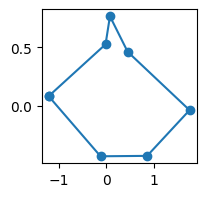

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
cities = random_cities(7)
opt_cities = optimise(cities)[0]
ax.plot(
    list(opt_cities[:, 0]) + [opt_cities[0, 0]],
    list(opt_cities[:, 1]) + [opt_cities[0, 1]],
    "o-",
);

Comme ça prend trop de temps, on tire au hasard des permutations, un nombre fini pour être sûr que l'algorithme se termine en un temps raisonnable.

In [20]:
def optimise_random(cities, n_perm):
    best_cities = None
    best_distance = None
    indices = list(range(cities.shape[0]))
    for i in range(n_perm):
        p = numpy.random.permutation(indices)
        p_cities = cities[p, :]
        d = distance(p_cities)
        if best_distance is None or d < best_distance:
            best_distance = d
            best_cities = p_cities
    return best_cities, best_distance


cities = numpy.array([[0, 0], [0, 2], [2, 2], [2, 0]])
optimise_random(cities, 10)

(array([[0, 2],
        [2, 2],
        [2, 0],
        [0, 0]]),
 8.0)

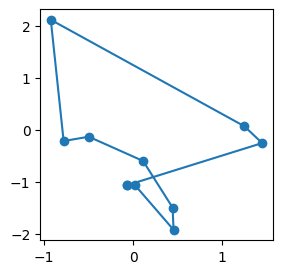

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
cities = random_cities(10)
opt_cities = optimise_random(cities, 10000)[0]
ax.plot(
    list(opt_cities[:, 0]) + [opt_cities[0, 0]],
    list(opt_cities[:, 1]) + [opt_cities[0, 1]],
    "o-",
);

Mais ce n'est pas parfait car il y a des croisements.

## Croisements

On écrit une fonction pour enlever des erreurs évidentes. La solution obtenue sera meilleure sans poutant être optimale.

In [23]:
def retournement1(cities):
    d0 = distance(cities)
    for i in range(cities.shape[0] - 1):
        for j in range(i + 1, cities.shape[0]):
            cities[i : j + 1, :] = cities[i : j + 1, :][::-1]
            d = distance(cities)
            if d < d0:
                d0 = d
            else:
                cities[i : j + 1, :] = cities[i : j + 1, :][::-1]
    return cities


cities = numpy.array([[0, 0], [0, 2], [2, 2], [2, 0]])
retournement1(cities)

array([[0, 0],
       [0, 2],
       [2, 2],
       [2, 0]])

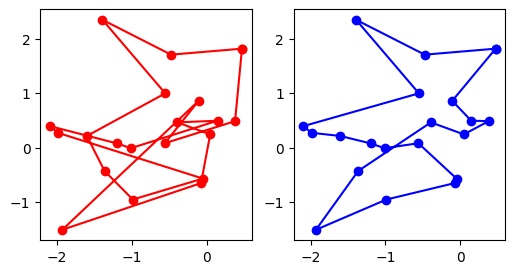

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
cities = random_cities(20)
opt_cities = optimise_random(cities, 10000)[0]
ax[0].plot(
    list(opt_cities[:, 0]) + [opt_cities[0, 0]],
    list(opt_cities[:, 1]) + [opt_cities[0, 1]],
    "or-",
)
retournement1(opt_cities)
ax[1].plot(
    list(opt_cities[:, 0]) + [opt_cities[0, 0]],
    list(opt_cities[:, 1]) + [opt_cities[0, 1]],
    "ob-",
);

En rouge, le résultat avant la fonction retournement, en bleu après. Ce n'est pas parfait même si c'est mieux. Il faut appliquer la fonction `retournement` qu'il faut appeler plusieurs fois ce qu'on fait dans la même fonction.

In [32]:
def retournement(cities):
    d0 = distance(cities)
    d_avant = d0 + 1
    while d0 < d_avant:
        d_avant = d0
        for i in range(cities.shape[0] - 1):
            for j in range(i + 1, cities.shape[0]):
                cities[i : j + 1, :] = cities[i : j + 1, :][::-1]
                d = distance(cities)
                if d < d0:
                    d0 = d
                else:
                    cities[i : j + 1, :] = cities[i : j + 1, :][::-1]
    return cities


cities = numpy.array([[0, 0], [0, 2], [2, 2], [2, 0]])
retournement(cities)

array([[0, 0],
       [0, 2],
       [2, 2],
       [2, 0]])

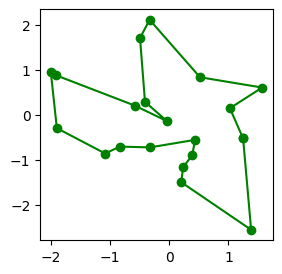

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
cities = random_cities(20)
opt_cities = optimise_random(cities, 10000)[0]
retournement(opt_cities)
ax.plot(
    list(opt_cities[:, 0]) + [opt_cities[0, 0]],
    list(opt_cities[:, 1]) + [opt_cities[0, 1]],
    "og-",
);

Et voilà, tout marche bien.